## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# import torch.nn as nn
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms, datasets

from tqdm import tqdm

## 設定

In [2]:
ID = 'rowID'
TARGET = 'Objective Variable_CL(L/hr/kg)'
TARGET_LOG = 'Objective Variable_CL(L/hr/kg)_Log'

TRAIN_PATH = '../data/train_fps.csv'
TEST_PATH = '../data/test_fps.csv'

BATCH_SIZE= 460

## データ用意

In [3]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.rename(columns={TARGET: 'y', TARGET_LOG: 'logy', ID:'ID'}, inplace=True)
df_test.rename(columns={ID:'ID'}, inplace=True)

X = df_train.drop(['ID', 'y', 'logy'], axis=1)
y = df_train.logy
print(X.shape, y.shape)

(1379, 2048) (1379,)


In [4]:
inps = torch.from_numpy(X.values)
tgts = torch.from_numpy(y.values)

In [5]:
num_workers = 8
dataset = TensorDataset(inps, tgts)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

In [6]:
# for data in train_loader:
#     a, b = data
#     print(a, a.size())
#     print(a.view(a.size(0), -1))
# #     print(b)
#     break

In [46]:
# TRAIN_PATH = './data/cifar/train'
# TEST_PATH = './data/cifar/test'
# TRANSFORM = transforms.Compose([
#     transforms.ToTensor(),
# ])
# train_data = datasets.ImageFolder(root=TRAIN_PATH, transform=TRANSFORM)
# test_data = datasets.ImageFolder(root=TEST_PATH, transform=TRANSFORM)

In [5]:
# num_workers = 4
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

## モデル用意

In [15]:
class VeryBasicNet(nn.Module):
    def __init__(self, input_features, output_neurons):
        super().__init__()
        self.fc = nn.Linear(input_features, output_neurons)
        
    def forward(self, X):
        # 普通は、ここで活性化関数かむ？
        return self.fc(X.view(X.size(0), -1))

### ハイパラ設定

In [16]:
INPUT_FEATURES = X.shape[1]
OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
model = VeryBasicNet(INPUT_FEATURES, OUTPUT_NEURONS)

In [18]:
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [19]:
for epoch in range(N_EPOCH):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.float().to(DEVICE)
        targets = targets.float().to(DEVICE)
        optimizer.zero_grad()
    
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(running_loss/len(train_loader)):.4f}')
        running_loss = 0.0

print('Finish training')

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([460])) that is different to the input size (torch.Size([460, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([459])) that is different to the input size (torch.Size([459, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [100/1000], Loss: 0.6907
Epoch: [200/1000], Loss: 0.6903
Epoch: [300/1000], Loss: 0.6902
Epoch: [400/1000], Loss: 0.6905
Epoch: [500/1000], Loss: 0.6904
Epoch: [600/1000], Loss: 0.6898
Epoch: [700/1000], Loss: 0.6911
Epoch: [800/1000], Loss: 0.6909
Epoch: [900/1000], Loss: 0.6898
Epoch: [1000/1000], Loss: 0.6903
Finish training


## Deepにする

In [57]:
MIDDLE_LAYER = 300

class BasicNet(nn.Module):
    def __init__(self, input_features, output_neurons):
        super().__init__()
        self.fc1 = nn.Linear(input_features, MIDDLE_LAYER)
        self.fc2 = nn.Linear(MIDDLE_LAYER, output_neurons)
        
    def forward(self, X):
        # 普通は、ここで活性化関数かむ？
        activation = nn.ReLU()
        X = activation(self.fc1(X))
        X = self.fc2(X)
        return X

In [58]:
INPUT_FEATURES = X.shape[1]
OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [59]:
model = BasicNet(INPUT_FEATURES, OUTPUT_NEURONS)

In [60]:
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [61]:
for epoch in range(N_EPOCH):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.float().to(DEVICE)
        targets = targets.float().to(DEVICE)
        optimizer.zero_grad()
    
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(running_loss/len(train_loader)):.4f}')
        running_loss = 0.0

print('Finish training')

Epoch: [100/1000], Loss: 0.6954
Epoch: [200/1000], Loss: 0.6888
Epoch: [300/1000], Loss: 0.6883
Epoch: [400/1000], Loss: 0.6836
Epoch: [500/1000], Loss: 0.6925
Epoch: [600/1000], Loss: 0.7021
Epoch: [700/1000], Loss: 0.6850
Epoch: [800/1000], Loss: 0.6856
Epoch: [900/1000], Loss: 0.6829
Epoch: [1000/1000], Loss: 0.6863
Finish training


## Conv

In [52]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.conv1 = nn.Conv1d(1, 8, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=5, stride=2, padding=2)
        # 半分のサイズになるpooling
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(16 * 128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
        
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        # viewはreshapeと同じ
        X = X.view(-1, 16 * 128)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)

In [53]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [54]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1
model = BasicCNN()

In [55]:
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [56]:
for epoch in range(N_EPOCH):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.float().to(DEVICE)
        targets = targets.float().to(DEVICE)
        optimizer.zero_grad()
    
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(running_loss/len(train_loader)):.4f}')
        running_loss = 0.0

print('Finish training')

RuntimeError: Expected 3-dimensional input for 3-dimensional weight 8 1 5, but got 2-dimensional input of size [32, 2048] instead

## BatchNormとDropout

In [7]:
# MIDDLE_LAYER = 300

# FC →Norm　→　ReLU →Dropout
        
# channelは３次元目の次数
class BnLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(
            in_dim, out_dim
        )
        self.bn = nn.BatchNorm1d(out_dim)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, X):
        # これ、self.dropout挟まなくていいの？
        return self.activation(self.bn(self.fc(X)))
        

class BnNet(nn.Module):
    def __init__(self, in_dim, layers, out_dim):
        super(BnNet, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.fc = nn.Linear(in_dim, layers[0])
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], out_dim)
        
        
    def forward(self, X):
        X = self.fc(X)
        for layer in self.layers:
            X = layer(X)
        # channelを統合
        return self.out(X)

In [8]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
IN_DIM = X.shape[1]
LAYERS = [512] * 4
OUT_DIM = 1
model = BnNet(IN_DIM, LAYERS, OUT_DIM)

In [10]:
print(model)

BnNet(
  (fc): Linear(in_features=2048, out_features=512, bias=True)
  (layers): ModuleList(
    (0): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): BnLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): PReLU(num_parameters=1)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (out): Linear(in_features=512, out_features=1, bias=True)
)


## LR range test

In [113]:
loss_func = nn.MSELoss()

loss_history = []
lr_list = [10**(i*(-1)) for i in range(7, 0, -1)]

for lr in tqdm(lr_list):
    model = BnNet(IN_DIM, LAYERS, OUT_DIM)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(N_EPOCH):
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, targets = data
            inputs = inputs.float().to(DEVICE)
            targets = targets.float().to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_func(outputs, targets)
            loss.backward()

            optimizer.step()
    #         scheduler.step()
    #         lr_history.append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item()

        (epoch + 1) == N_EPOCH and loss_history.append(running_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(running_loss/len(train_loader)):.4f}')
            running_loss = 0.0

    print('Finish training')

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: [10/100], Loss: 1.0939
Epoch: [20/100], Loss: 1.0822
Epoch: [30/100], Loss: 1.0706
Epoch: [40/100], Loss: 1.0633
Epoch: [50/100], Loss: 1.0551
Epoch: [60/100], Loss: 1.0508
Epoch: [70/100], Loss: 1.0348
Epoch: [80/100], Loss: 1.0280
Epoch: [90/100], Loss: 1.0223


 14%|█▍        | 1/7 [08:06<48:37, 486.20s/it]

Epoch: [100/100], Loss: 1.0120
Finish training
Epoch: [10/100], Loss: 0.7785
Epoch: [20/100], Loss: 0.7914
Epoch: [30/100], Loss: 0.7329
Epoch: [40/100], Loss: 0.7208
Epoch: [50/100], Loss: 0.7097
Epoch: [60/100], Loss: 0.7082
Epoch: [70/100], Loss: 0.7006
Epoch: [80/100], Loss: 0.7151
Epoch: [90/100], Loss: 0.7131


 29%|██▊       | 2/7 [16:29<40:56, 491.36s/it]

Epoch: [100/100], Loss: 0.7149
Finish training
Epoch: [10/100], Loss: 0.6996
Epoch: [20/100], Loss: 0.6906
Epoch: [30/100], Loss: 0.6992
Epoch: [40/100], Loss: 0.6910
Epoch: [50/100], Loss: 0.6922
Epoch: [60/100], Loss: 0.6896
Epoch: [70/100], Loss: 0.6879
Epoch: [80/100], Loss: 0.6895
Epoch: [90/100], Loss: 0.6917


 43%|████▎     | 3/7 [24:47<32:53, 493.47s/it]

Epoch: [100/100], Loss: 0.6942
Finish training
Epoch: [10/100], Loss: 0.7078
Epoch: [20/100], Loss: 0.7015
Epoch: [30/100], Loss: 0.6913
Epoch: [40/100], Loss: 0.6947
Epoch: [50/100], Loss: 0.6906
Epoch: [60/100], Loss: 0.7070
Epoch: [70/100], Loss: 0.6888
Epoch: [80/100], Loss: 0.6957
Epoch: [90/100], Loss: 0.7046


 57%|█████▋    | 4/7 [32:48<24:29, 489.68s/it]

Epoch: [100/100], Loss: 0.6869
Finish training
Epoch: [10/100], Loss: 0.7228
Epoch: [20/100], Loss: 0.6841
Epoch: [30/100], Loss: 0.6892
Epoch: [40/100], Loss: 0.6913
Epoch: [50/100], Loss: 0.6864
Epoch: [60/100], Loss: 0.6887
Epoch: [70/100], Loss: 0.6923
Epoch: [80/100], Loss: 0.6909
Epoch: [90/100], Loss: 0.6877


 71%|███████▏  | 5/7 [40:31<16:03, 481.64s/it]

Epoch: [100/100], Loss: 0.6902
Finish training
Epoch: [10/100], Loss: 0.6953
Epoch: [20/100], Loss: 0.6913
Epoch: [30/100], Loss: 0.6958
Epoch: [40/100], Loss: 0.7129
Epoch: [50/100], Loss: 0.6911
Epoch: [60/100], Loss: 0.6924
Epoch: [70/100], Loss: 0.6945
Epoch: [80/100], Loss: 0.6951
Epoch: [90/100], Loss: 0.6900


 86%|████████▌ | 6/7 [47:58<07:51, 471.13s/it]

Epoch: [100/100], Loss: 0.6903
Finish training
Epoch: [10/100], Loss: 0.6908
Epoch: [20/100], Loss: 0.6888
Epoch: [30/100], Loss: 0.6839
Epoch: [40/100], Loss: 0.6876
Epoch: [50/100], Loss: 0.6876
Epoch: [60/100], Loss: 0.6917
Epoch: [70/100], Loss: 0.6883
Epoch: [80/100], Loss: 0.6879
Epoch: [90/100], Loss: 0.6862


100%|██████████| 7/7 [55:33<00:00, 476.19s/it]

Epoch: [100/100], Loss: 0.6919
Finish training


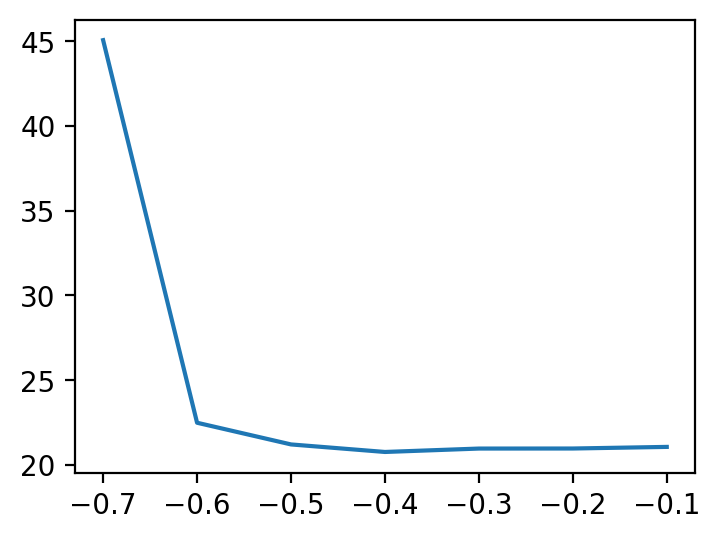

In [114]:
plt.figure(figsize=(4, 3), dpi=200)

x = [-.1 * i for i in range(7, 0, -1)]
y = loss_history

plt.plot(x, y)
plt.show()

In [13]:
model = BnNet(IN_DIM, LAYERS, OUT_DIM)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10)

lr_history = []
loss_history = []

for epoch in range(N_EPOCH):
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.float().to(DEVICE)
        targets = targets.float().to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        loss.backward()

        lr_history.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        loss_history.append(loss.item())
        if i == 6:
            break

    break

print('Finish training')

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([460])) that is different to the input size (torch.Size([460, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Finish training


/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([459])) that is different to the input size (torch.Size([459, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


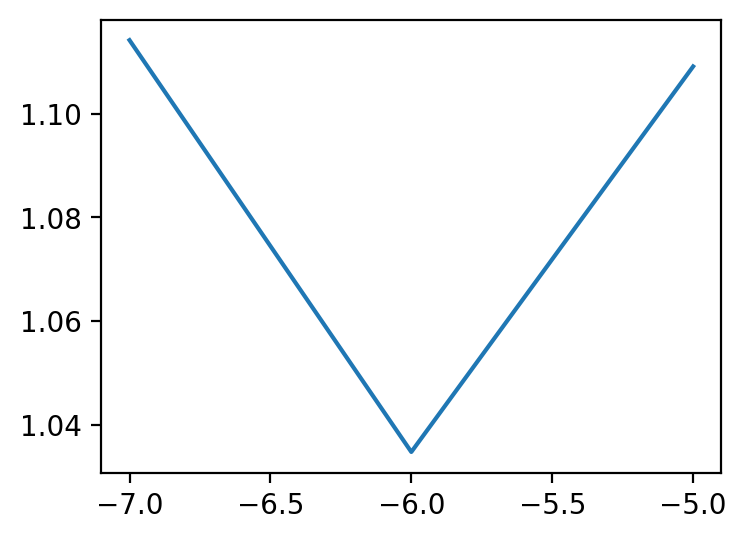

In [14]:
plt.figure(figsize=(4, 3), dpi=200)

x = np.log10(np.array(lr_history))
y = np.sqrt(np.array(loss_history))

plt.plot(x, y)
plt.show()

## CLR

* base_lr: Lossの変化が急になり始めた点
* max_lr: Lossの変化がなだらかになる直前の点
* step_size: 1Epochに回るイテレーションサイズ(つまり、学習データ量÷バッチサイズ)の2倍〜10倍

In [108]:
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.003, 0.01, cycle_momentum=False)

In [109]:
lr_history = []

for epoch in range(N_EPOCH):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.float().to(DEVICE)
        targets = targets.float().to(DEVICE)
        optimizer.zero_grad()
    
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        loss.backward()

        optimizer.step()
#         scheduler.step()
#         lr_history.append(optimizer.param_groups[0]['lr'])
        
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(running_loss/len(train_loader)):.4f}')
        running_loss = 0.0

print('Finish training')

Epoch: [10/100], Loss: 1.0138
Epoch: [20/100], Loss: 1.0160
Epoch: [30/100], Loss: 0.9888
Epoch: [40/100], Loss: 1.0050
Epoch: [50/100], Loss: 0.9750
Epoch: [60/100], Loss: 0.9698
Epoch: [70/100], Loss: 0.9693
Epoch: [80/100], Loss: 0.9939


KeyboardInterrupt: 

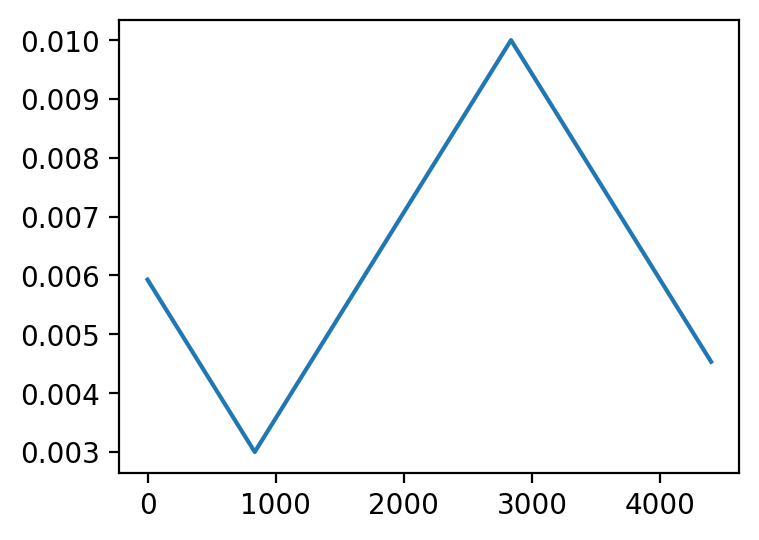

In [93]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(len(lr_history))]
y = lr_history

plt.plot(x, y)
plt.show()

## LR range test

In [ ]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    test_loss = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)          
        outputs = model(inputs)

        loss = loss_func(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy on 10000 test image: %d %%" % (100 * correct / total))
print("Validation loss:{:.4f}".format(test_loss / (10000/BATCH_SIZE)))

## BatchNormとDropout Conv

In [31]:
# MIDDLE_LAYER = 300

# FC →Norm　→　ReLU →Dropout

# BN用のmoduleを作って、それをFC層で呼び出す感じにする
# class BnLayer(nn.Module):
#     def __init__(self, out_chan):
#         super.__init__()
#         self.dropout = nn.Dropout(p=0.2)
#         self.bn = nn.BatchNorm1d(out_chan)
        
#     def forward(self, X):
#         activation = nn.ReLU()
#         return self.bn(activation(X))
        
# channelは３次元目の次数
class BnLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=2):
        super().__init__()
#         self.fc = nn.Linear(in_chan, out_chan)
        self.bn = nn.BatchNorm1d(out_channel)
        # sizeが半分になるconvolution 2048 →1024　→ 512
        self.conv = nn.Conv1d(
            in_channel, out_channel,
            kernel_size=kernel_size, stride=stride, padding=1, bias=False
        )
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=0.2)

        
    def forward(self, X):
        # これ、self.dropout挟まなくていいの？
#         return self.activation(self.bn(self.fc(X)))
        return self.bn(self.activation(self.conv(X)))
        

class ConvBnNet(nn.Module):
    def __init__(self, layers, out_dim):
        super(ConvBnNet, self).__init__()
        # 大きさ変わらないConv　出力の次元が増える
        self.conv1 = nn.Conv1d(1, layers[0], kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], out_dim)
        
        
    def forward(self, X):
        X = self.conv1(X)
        for layer in self.layers:
            X = layer(X)
        # channelを統合
        X = F.adaptive_avg_pool1d(X, 1)
        return F.prelu(self.out(X), dim=-1)

In [32]:
# INPUT_FEATURES = X.shape[1]
# OUTPUT_NEURONS = 1

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [33]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
LAYERS = [10, 20, 40, 80]
OUT_DIM = 1
model = ConvBnNet(LAYERS, OUT_DIM)

In [34]:
loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [35]:
for epoch in range(N_EPOCH):
    inputs = torch.tensor(X.values).float().to(DEVICE)
    targets = torch.tensor(y.values).float().to(DEVICE)
    optimizer.zero_grad()
    
    outputs = model(inputs)
    
    loss = loss_func(outputs, targets)
    loss.backward()
    
    optimizer.step()

    
    if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}')
            running_loss = 0.0


RuntimeError: Expected 3-dimensional input for 3-dimensional weight 10 1 5, but got 2-dimensional input of size [1379, 2048] instead